# **Evaluating Natural Language Generation w/ a RAG Architecture**

### Overview
In this notebook you will explore methods to evaluate NLG with a RAG (Retrieval Augmented Generation) architecture. RAG is a common method used to improve LLM results and reduce hallucnations by 'grounding' the LLM resposne using information retrieval. 

There are two important questions when evaluation a chatbot that uses RAG:
1. How good is the data being retreived (called the context) for a given question?
2. How good is my LLM at utilizing the provided context?  

For each of the questions above, there are two methods of assessment:
1. Groundedness - A LLM assessment of Groundedness (see [Notebook 1](./1_gpt_evaluation.ipynb) for details)
2. Similarity - The cosine similarity between the two embeddings vectors

The combination of question/method assessments discussed above leads to the use of 4 metrics. Question/Context Groundedness, Question/Context Similarity, Answer/Context Groundedness, and Answer/Context Similarity.

This notebook will use a sample Azure PromptFlow to generate chat responses using RAG, then explore a custom evaluation PromptFlow to assess the 4 metrics explained above.

 **_Go Deeper_**  
[OpenAI - Text Embedding and Similarity](https://openai.com/blog/introducing-text-and-code-embeddings)  
[GPT 4 can correctly classify binary relevence 86.3% of the time on average](https://arxiv.org/pdf/2312.09601.pdf)
  
**_Prerequisites_**  
  
Ensure that your environment is setup by completing the steps outlines in [0_setup.ipynb](./0_setup.ipynb)

## 1a. Setup Open AI embedding model connection

- Via the Azure Portal OpenAI or AI studio create and setup an embedding model deployment.
- Example:  
  
  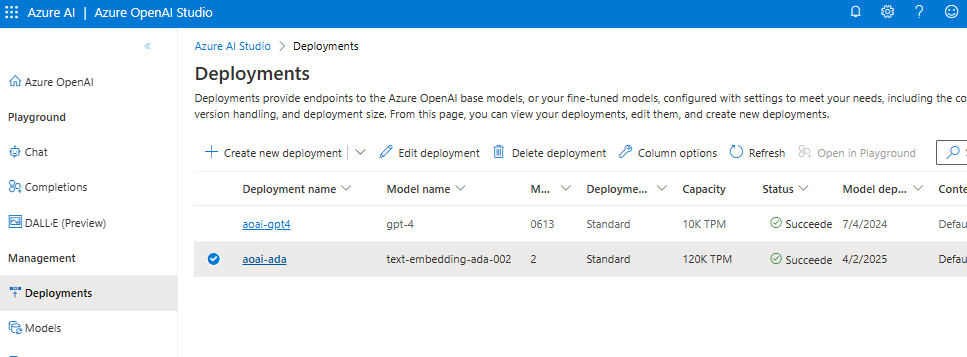

## 1b. Upload Sample Input Data & Indexed Data Source

In [1]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
import os
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv(), override=True)
print(os.getenv("WORKSPACE_NAME"))

# authenticate
credential = DefaultAzureCredential()

# Get a handle to the workspace
ml_client = MLClient(
    credential=credential,
    subscription_id = os.environ.get('SUBSCRIPTION_ID'),
    resource_group_name = os.environ.get('RESOURCE_GROUP_NAME'),
    workspace_name = os.environ.get('WORKSPACE_NAME'),
)

zs-aml


In [2]:
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes
import time

local_path = "../data/inputs/sample_rag_inputs.csv"
# set the version number of the data asset to the current UTC time
v1 = time.strftime("%Y.%m.%d.%H%M%S", time.gmtime())


my_data = Data(
    name="rag-chat-sample-inputs",
    version=v1,
    description="Sample inputs for rag chat flow",
    path=local_path,
    type=AssetTypes.URI_FILE,
)

# create data asset
ml_client.data.create_or_update(my_data)

print(f"Data asset created. Name: {my_data.name}, version: {my_data.version}")

Data asset created. Name: rag-chat-sample-inputs, version: 2024.01.26.220359


## 2. Run Simple Chat & GPT Evaluation PromptFlow Jobs
In this section you will run a [sample RAG chat](../src/promptflow/sample_chat_flows/rag_chat_wiki/flow.dag.yaml) against a small sample dataset. The chat pattern augments the LLM with data from Wikipedia to 'ground' the model.

Then, as part of the same job, you will evaluate the GPT metrics above using an [evaluation PromptFlow](../src/promptflow/evaluation_flows/rag_gpt_eval/)

Both the simple chat and the evaluation utilize the AOAI connection established during setup and cooresponding GPT4 deployment.

##### **IMPORTANT**: _Please take a moment to analyze in depth the Simple Chat, Evaluation Flow, and the sample dataset linked above_

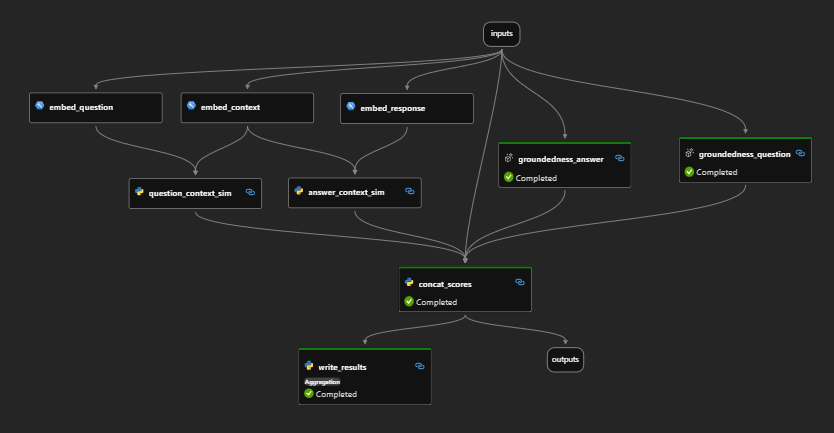

In [11]:
from promptflow import PFClient

# PFClient can help manage your runs and connections.
pf = PFClient()

# Define Flows and Data
rag_chat_flow = "../src/promptflow/sample_chat_flows/rag_chat_wiki" # set the flow directory
rag_eval_flow = "../src/promptflow/evaluation_flows/rag_eval" # set flow directory
data = "../data/inputs/sample_rag_inputs.csv" # set the data file

# Run chat flow to generate chat results
rag_chat_run = pf.run(
    flow=rag_chat_flow,
    data=data,
    stream=False,
    column_mapping={  # map the url field from the data to the url input of the flow
      "input": "${data.input}",
    }
) 

pf.stream(rag_chat_run)

2024-01-26 16:55:07 -0600  498143 execution.bulk     INFO     Process 498143 started.
2024-01-26 16:55:07 -0600  498148 execution.bulk     INFO     Process 498148 started.
2024-01-26 16:55:07 -0600  498152 execution.bulk     INFO     Process 498152 started.
2024-01-26 16:55:07 -0600  498157 execution.bulk     INFO     Process 498157 started.
2024-01-26 16:55:07 -0600  498177 execution.bulk     INFO     Process 498177 started.
2024-01-26 16:55:07 -0600  498180 execution.bulk     INFO     Process 498180 started.
2024-01-26 16:55:07 -0600  498193 execution.bulk     INFO     Process 498193 started.
2024-01-26 16:55:07 -0600  498199 execution.bulk     INFO     Process 498199 started.
2024-01-26 16:55:07 -0600  498203 execution.bulk     INFO     Process 498203 started.
2024-01-26 16:55:07 -0600  498210 execution.bulk     INFO     Process 498210 started.
2024-01-26 16:55:07 -0600  498224 execution.bulk     INFO     Process 498224 started.
======= Run Summary =======

Run name: "rag_chat_wiki_

In [12]:
# Run evaluation flow to evaluate chat results
rag_eval_run = pf.run(
    flow=rag_eval_flow,
    data=data,
    run=rag_chat_run,
    stream=False,
    column_mapping={  # map the url field from the data to the url input of the flow
      "question": "${data.input}",
      "response": "${run.outputs.answer}",
      "context": "${run.outputs.context}"
    }
)

pf.stream(rag_eval_run)

2024-01-26 16:56:35 -0600  498774 execution.bulk     INFO     Process 498774 started.
2024-01-26 16:56:35 -0600  498780 execution.bulk     INFO     Process 498780 started.
2024-01-26 16:56:35 -0600  498798 execution.bulk     INFO     Process 498798 started.
2024-01-26 16:56:35 -0600  498802 execution.bulk     INFO     Process 498802 started.
2024-01-26 16:56:35 -0600  498806 execution.bulk     INFO     Process 498806 started.
2024-01-26 16:56:35 -0600  498816 execution.bulk     INFO     Process 498816 started.
2024-01-26 16:56:35 -0600  498821 execution.bulk     INFO     Process 498821 started.
2024-01-26 16:56:35 -0600  498835 execution.bulk     INFO     Process 498835 started.
2024-01-26 16:56:35 -0600  498844 execution.bulk     INFO     Process 498844 started.
2024-01-26 16:56:35 -0600  498853 execution.bulk     INFO     Process 498853 started.
2024-01-26 16:56:35 -0600  498867 execution.bulk     INFO     Process 498867 started.
======= Run Summary =======

Run name: "rag_eval_varia

## 3.  View Results  
To view outputs in detail analyze the [output data](../data/outputs/rag_eval_results.json) directly

In [13]:
import pandas as pd

output_data = "../data/outputs/rag_eval_results.json"

output_df = pd.read_json(output_data)
display(output_df)

,question,answer,context,groundedness_answer,goundedness_question,question_context_sim,answer_context_sim
0,How do volcanoes erupt?,"Volcanoes erupt when lava, tephra (which inclu...",Taal Volcano IPA taal Tagalog Bulkang Taal is ...,5,5,0.809810,0.841223
1,How does photosynthesis work?,Photosynthesis is a process that converts carb...,C4 carbon fixation or the HatchSlack pathway i...,5,3,0.825237,0.841483
2,Who invented the light bulb?,The first electric light bulbs with a carbon f...,Edison light bulbs also known as filament ligh...,5,5,0.842305,0.914905
3,What is the Great Barrier Reef and why is it i...,The Great Barrier Reef is the world's largest ...,The Great Barrier Reef is the worlds largest c...,5,5,0.867540,0.965269
4,Who is Harry Potter's best friend?,Harry Potter's best friends are Hermione Grang...,This is a list of characters in the Harry Pott...,5,5,0.831409,0.884653
5,What is the largest planet in our solar system?,The largest planet in our Solar System is Jupi...,The Solar Systemc is the gravitationally bound...,5,5,0.852414,0.889276
6,How do airplanes fly?,The document does not provide specific informa...,Stick and Rudder An Explanation of the Art of ...,3,1,0.816453,0.803651
7,Who was the first person to set foot on the moon?,The first person to set foot on the moon was N...,One Small Step may refer to Main pageContentsC...,5,5,0.877292,0.926622
8,How are rainbows formed?,Rainbows are formed by an optical phenomenon i...,A rainbow is an optical phenomenon caused by r...,5,5,0.883983,0.955982
9,How do earthquakes happen?,"I'm sorry, but the provided sources do not con...",On 6 February 2023 at 0417TRT 0117UTC a Mw78 e...,3,3,0.810454,0.771079


In [ ]:
# TODO - add charts to compare similarity scores to GPT groundedness scores